In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [1]:
%matplotlib inline

In [2]:
import os, sys, inspect
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(
        os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],
                     '..', '..', 'labeled-experiments', 'nn-classifiers')))
print 'Added {0} to path.'.format(cmd_folder)
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

Added /Users/an/dev-repos/factory-robot-simulator/labeled-experiments/nn-classifiers to path.


In [3]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import matplotlib.colors
import theano
import theano.tensor as T
import numpy as np
# from labeling_network import FullyConnectedLayer, ConvPoolLayer

import time
import datetime

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [4]:
dataPath = '../../../factory-robot-data/imgs_2015-10-18-2/'

In [5]:
n_direction_sensors = 9
n_classes = 2
rng = np.random.RandomState()

In [6]:
load_time_start = time.time()
train_data, valid_data, test_data = lbln.load_data_shared(
                     dataPath,
                     'capture',
                     dataPath + 'labels.dat',
                     n_train=16000,
                     n_validation=2000,
                     n_test=100,
                     label_mask=-1,
                     n_direction_sensors=n_direction_sensors,
                     n_classes=n_classes,
                     shuffle_rng=rng,
                     hsv='hsv')

# reverse target and label
train_data = train_data[1], train_data[0]
valid_data = valid_data[1], valid_data[0]
test_data = test_data[1], test_data[0]


print 'Loading data took {0:.5} seconds'.format(time.time() - load_time_start)

Loading data took 56.156 seconds


In [8]:
X_train = train_data[0].get_value()
y_train = train_data[1].get_value()
X_test = valid_data[0].get_value()
y_test = valid_data[1].get_value()

### Train the Network. 

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

model = Sequential()
model.add(Dense(400, input_dim=18, init='glorot_normal'))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(2000, init='glorot_normal'))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(64*64*3, init='glorot_normal'))
model.add(Activation('sigmoid'))



In [ ]:
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', 
              optimizer='adam')

In [52]:
file_prefix = 'trained-networks/dec' + datetime.now().strftime('%Y%m%d%H%M%S') 
open(file_prefix + '.json', 'w').write(model.to_json())


checkpoint = ModelCheckpoint(file_prefix + '.h5')
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

model.fit(X_train, y_train, validation_split=0.1, nb_epoch=1, batch_size=32,
          callbacks=[checkpoint, early_stopping])
score = model.evaluate(X_test, y_test, batch_size=16)

Train on 14400 samples, validate on 1600 samples
Epoch 1/1
2000/2000 [==============================] - 1s     


In [51]:
score = model.evaluate(X_test, y_test, batch_size=16)
print score

2000/2000 [==============================] - 1s     
0.0029889867669


#### Load network.

In [34]:
import time
from keras.models import model_from_json
print 'Loading and compiling model. This may take a while.'
dir_name = 'trained-networks/'
# architecture_filename = dir_name + 'json.dat'
weights_filename = dir_name + 'dec20151025234632.h5'

time.sleep(0.1)


tic = time.time()
# print 'loading model architecture...'
# model = model_from_json(open(architecture_filename).read())

print 'loading model weights...'
model.load_weights(weights_filename)
toc = time.time()
print 'loading the model took {0} seconds'.format(toc - tic)

Loading and compiling model. This may take a while.
loading model weights...
loading the model took 0.216398000717 seconds


### Determine mean squared loss on test images 

In [41]:
errs = []
for x, t in zip(X_test, y_test):
    t_hat = model.predict(np.asarray([x]))
    errs.append(np.mean((t_hat - t) ** 2))
print 'MSE: {0}'.format(np.mean(errs))

MSE: 0.00298482140788


### Determine all Losses on test images.

In [38]:
def show_image(img, hsv=None):
    if hsv is None:
        plt.imshow(img.reshape(64, 64, 3), interpolation='nearest')
        plt.show()
    else:
        plt.imshow(matplotlib.colors.hsv_to_rgb(img.reshape(64, 64, 3)), interpolation='nearest')
        plt.show()

 --- Worst predictions: ---
Loss:       0.0230344613815


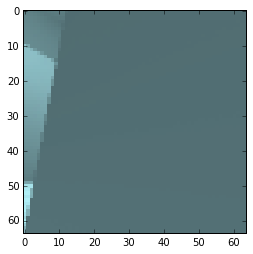

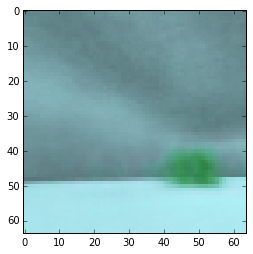

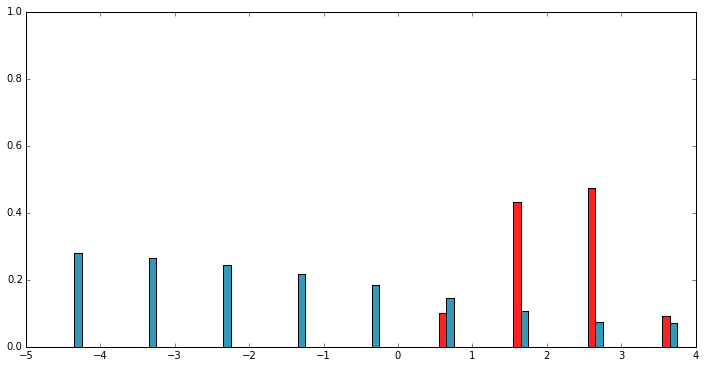

---------
Loss:       0.0207793764545


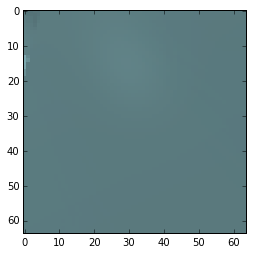

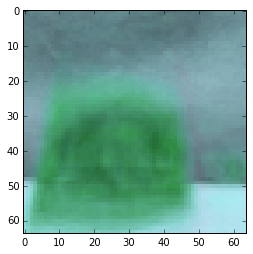

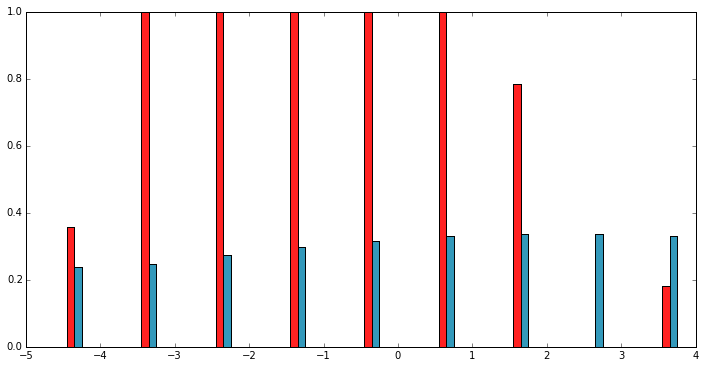

---------



--- Median prediction ---
Loss:       0.00213813196167


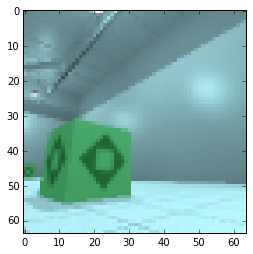

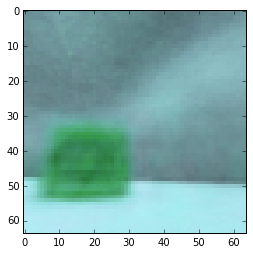

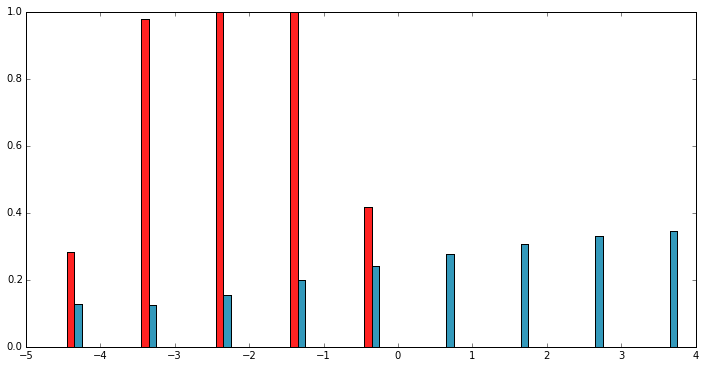

---------
Loss:       0.00213797856372


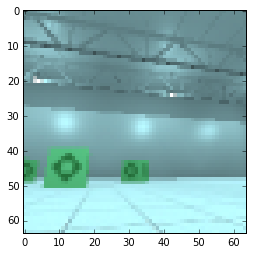

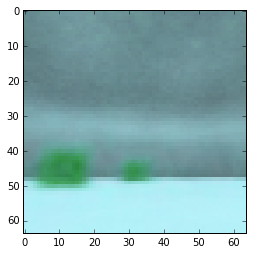

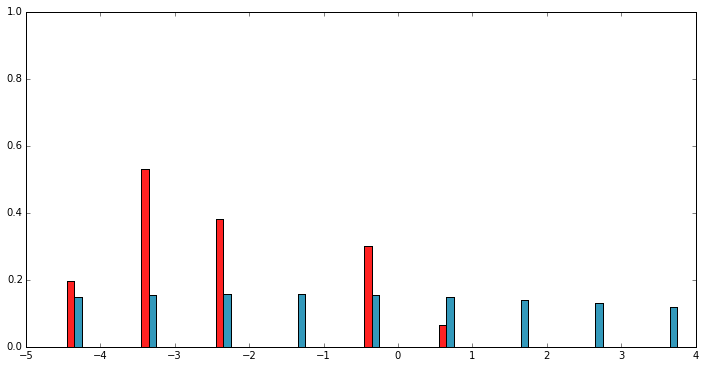

---------
Loss:       0.00213758728397


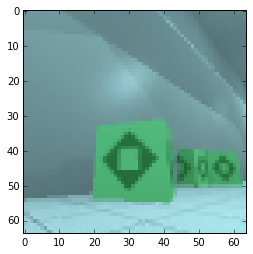

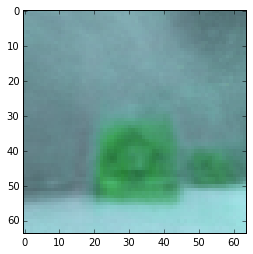

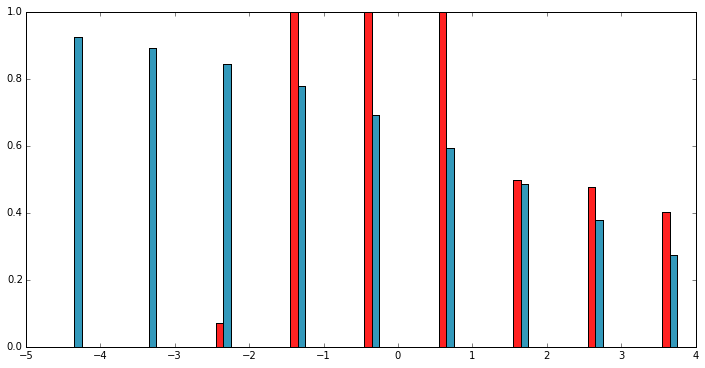

---------
Loss:       0.00213701572665


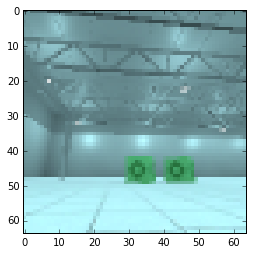

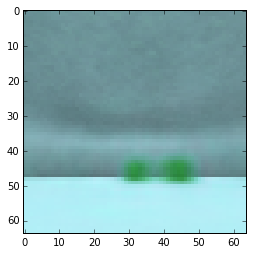

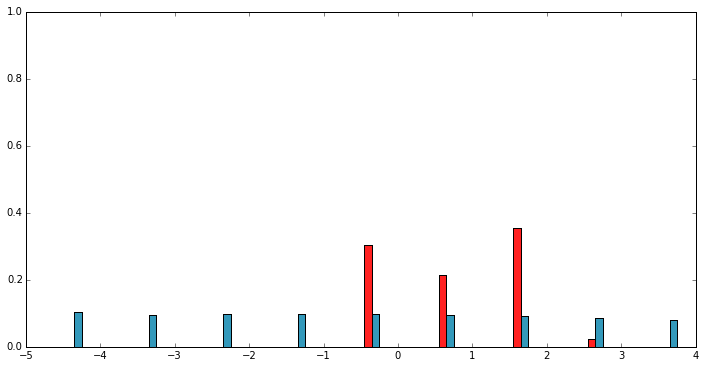

---------
Loss:       0.00213594353638


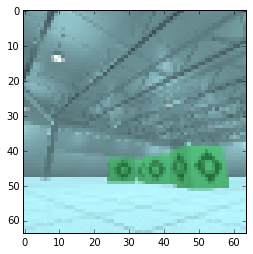

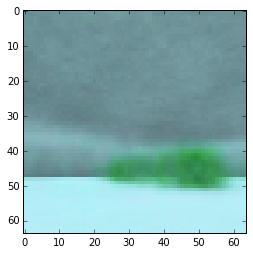

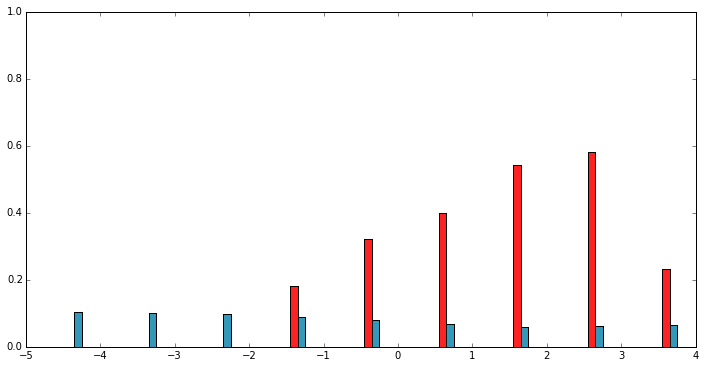

---------
Loss:       0.00213577854026


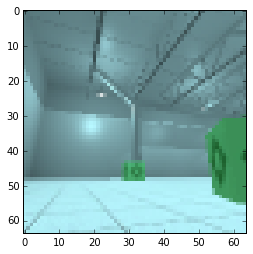

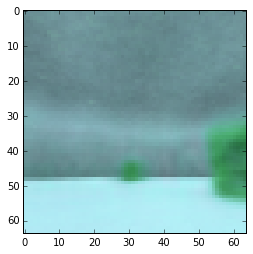

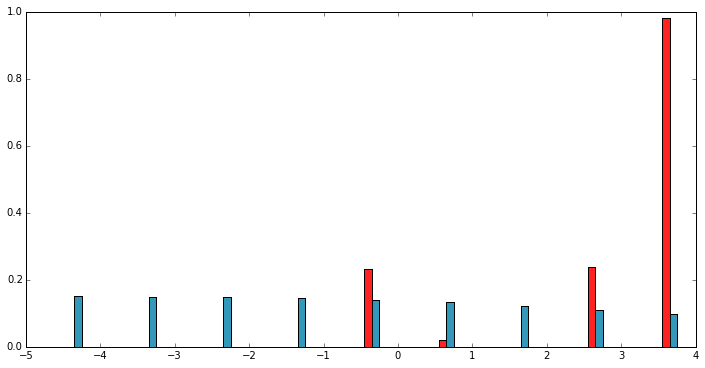

---------
Loss:       0.00213445848467


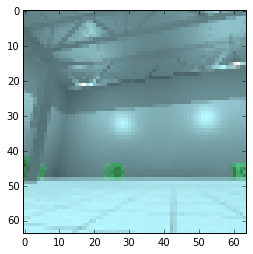

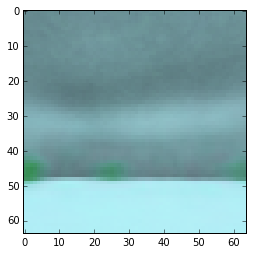

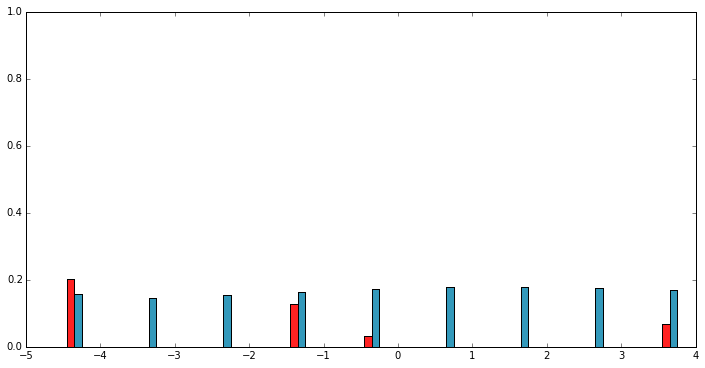

---------
Loss:       0.00213275961614


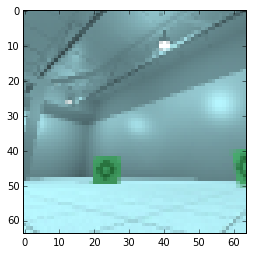

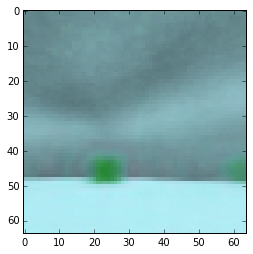

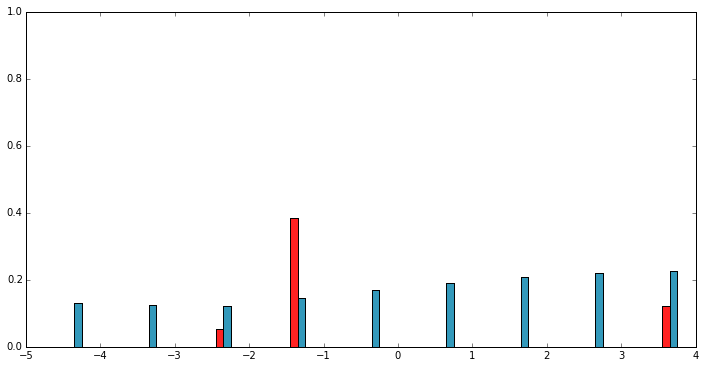

---------


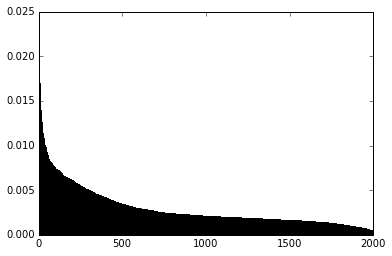

In [49]:
def print_classification(index, n_classes, n_directions):
#     print 'Target:    ', classifications[index][1]
#     print 'Prediction:', classifications[index][2]
    print 'Loss:      ', classifications[index][3]
    show_image(classifications[index][1], hsv='hsv')
    show_image(classifications[index][2], hsv='hsv')
    
    
    
    fig = plt.figure(figsize=(12,6))
    ax_left = fig.add_subplot(111)
    ax_left.set_ylim(0,1)
    bar_width = 0.1
    chart_colors = ['#ff2222', '#3399bb', '#55aa22', '#bbee33', '#881144']
    for i in xrange(n_classes):
        ax_left.bar(np.arange(n_directions)-(n_directions/2) + (i - n_directions/2.0 + 0.5)*bar_width,
               classifications[index][0][i*n_directions: (i+1)*n_directions],
               bar_width,
               color=chart_colors[i],
               align='center')
    plt.show()
    print '---------'
        


# Determine all errors on the test images
classifications = []
for x, t in zip(X_test, y_test):
    prediction = model.predict(np.asarray([x]))[0]
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))


print '--- Worst predictions: ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)
print_classification(0, n_classes, n_direction_sensors)
print_classification(1, n_classes, n_direction_sensors)

print '\n\n'
print '--- Median prediction ---'
n_displayed_median = 8
for i in xrange(-n_displayed_median/2, n_displayed_median/2):
    print_classification(len(classifications)/2 + i, n_classes, n_direction_sensors)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(classifications)), np.asarray(classifications)[:, 3])
plt.show()